This notebook explores, analyzes, and models at-risk MMSA (Metropolitan or Micropolitan Statistical Areas) in the U.S. The goal of this notebook is to demonstrate data manipulation on real-world, messy data, and to build simple models capturing much of the pattern in the data. This notebook outlines a pretty straightforward data science process, from conceiving an idea to relaying model results.   

The dataset analyzed is from: https://github.com/fivethirtyeight/data/tree/master/covid-geography.

This notebook is purely a demonstration of a data science project, and is not meant to contest the analysis or findings of the original article (https://fivethirtyeight.com/features/how-one-high-risk-community-in-rural-south-carolina-is-bracing-for-covid-19/) for which this dataset was used.  

Hope you enjoy this project!

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats
import random
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.ensemble import RandomForestRegressor

pd.options.display.max_rows = 999 # to display all rows
pd.options.display.max_columns = 999 # to display all columns

We first read in the file.

In [2]:
mmsa_df = pd.read_csv("Data/mmsa-icu-beds.txt", sep = ",")

Let's quickly inspect our dataset.

In [3]:
mmsa_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 136 entries, 0 to 135
Data columns (total 7 columns):
MMSA                      136 non-null object
total_percent_at_risk     136 non-null object
high_risk_per_ICU_bed     135 non-null float64
high_risk_per_hospital    135 non-null float64
icu_beds                  135 non-null float64
hospitals                 135 non-null float64
total_at_risk             136 non-null float64
dtypes: float64(5), object(2)
memory usage: 7.6+ KB


There are 136 observations (rows) in the dataset. For four of the columns, there is a missing value (`135 non-null` instead of an expected `136 non-null`). 

Let's identify the observation with the missing value.

In [4]:
mmsa_df[mmsa_df.isnull().any(axis = 1)]

,MMSA,total_percent_at_risk,high_risk_per_ICU_bed,high_risk_per_hospital,icu_beds,hospitals,total_at_risk
0,"San Juan-Carolina-Caguas, PR",52.88%,NaN,NaN,NaN,NaN,923725.203


The MMSA with the missing values is San Juan-Carolina-Caguas, PR. Since only one observation contains missing values, we are okay simply dropping this observation from the dataset. 

Imputing the missing values is an option, however, for this geographical dataset, further analysis would be needed to identify what type of imputation would be necessary (mean of all observations, mean of observations most like San Juan-Carolina-Caguas, PR, etc.), which is beyond the scope of this project. Without losing too much information, we can safely drop this observation.

In [5]:
mmsa_df = mmsa_df.set_index("MMSA")
mmsa_df = mmsa_df.drop("San Juan-Carolina-Caguas, PR", axis = 0) # axis = 0 is for rows
mmsa_df = mmsa_df.reset_index()

We see that `total_percent_at_risk` is an `object` datatype. Let's convert this to a `float`. 

`[^\d]` is the regular expression to get non-digits. We replace the non-digits with nothing, `('')`. We convert the `object` to an integer, then divide the integer by 10,000 to get the percentage in decimal form.

In [6]:
mmsa_df["total_percent_at_risk"] = mmsa_df["total_percent_at_risk"].str.replace('[^\d]', '').astype(int) / 10000

Since beds in an ICU (Intensive Care Unit) and Hospitals cannot be partial values, let's convert these datatypes from `float` to integer datatype.

In [7]:
mmsa_df["icu_beds"] = mmsa_df["icu_beds"].astype(int)
mmsa_df["hospitals"] = mmsa_df["hospitals"].astype(int)

We are going to create some additional columns in our dataset. This allows us to have additional features in our model, and capture more insight of our data.

Let's calculate the total population.

In [8]:
mmsa_df["total_population"] = mmsa_df["total_at_risk"] / mmsa_df["total_percent_at_risk"]
mmsa_df["total_population"] = mmsa_df["total_population"].round().astype(int)

We extract which MMSA are metropolitan divisions (Note, Metropolitan Division is the most dense per county MMSA, Metropolitan Statistical Area is second, and Micropolitan Statistical Area is the smallest).

In [9]:
mmsa_df["metro_div"] = mmsa_df["MMSA"].astype(str).str.extract("(Metropolitan Division)", expand = False)
mmsa_df["metro_div"] = np.where(mmsa_df["metro_div"].notnull(), 1, 0)

We extract state from MMSA. We engineer a feature indicating which MMSA span across multiple states. 

In [10]:
mmsa_df["State"] = mmsa_df["MMSA"].str.split(",").str.get(1)
mmsa_df["multiple_states_len"] = mmsa_df["State"].str.strip().str.len()
mmsa_df["multiple_states"] = np.where(mmsa_df["multiple_states_len"] > 2, 1, 0)
mmsa_df = mmsa_df.drop(["State","multiple_states_len"], axis = 1) # axis = 1 is for columns

We inspect our data after these initial manipulations.

In [11]:
mmsa_df.describe()

,total_percent_at_risk,high_risk_per_ICU_bed,high_risk_per_hospital,icu_beds,hospitals,total_at_risk,total_population,metro_div,multiple_states
count,135.000000,135.000000,135.000000,135.000000,135.000000,1.350000e+02,1.350000e+02,135.000000,135.000000
mean,0.602318,1947.356729,43787.067561,360.185185,13.762963,6.652885e+05,1.158136e+06,0.125926,0.237037
std,0.061286,720.661896,17992.274197,450.580508,15.377929,8.878035e+05,1.647622e+06,0.333001,0.426849
min,0.389200,413.667706,6770.190000,8.000000,1.000000,1.794153e+04,2.795100e+04,0.000000,0.000000
25%,0.559400,1487.781317,31005.455625,89.500000,5.000000,1.566108e+05,2.474370e+05,0.000000,0.000000
50%,0.604800,1923.676063,42460.360000,221.000000,9.000000,3.921263e+05,6.155250e+05,0.000000,0.000000
75%,0.634650,2321.085003,56583.347585,489.500000,18.000000,9.387130e+05,1.597124e+06,0.000000,0.000000
max,0.807300,4489.848750,91771.345830,2777.000000,100.000000,6.165102e+06,1.133708e+07,1.000000,1.000000


The ranges of our fields seem very large. The natural logarithm could be taken to smooth out this spread of the data. This will also help us when it comes to modeling by minimizing heteroskedasticity and allowing our coefficients to be more easily interpretable (percent change). 

Let's take the log of the continuous variables.

In [12]:
mmsa_df["total_at_risk_log"] = np.log(mmsa_df["total_at_risk"])
mmsa_df["total_population_log"] = np.log(mmsa_df["total_population"])
mmsa_df["icu_beds_log"] = np.log(mmsa_df["icu_beds"])
mmsa_df["hospitals_log"] = np.log(mmsa_df["hospitals"])

Visually inspecting these fields also affirms taking the natural log. The data are naturally skewed. Taking the natural log mostly returns the data to follow a normal distribution, necessary for linear regression modeling. 

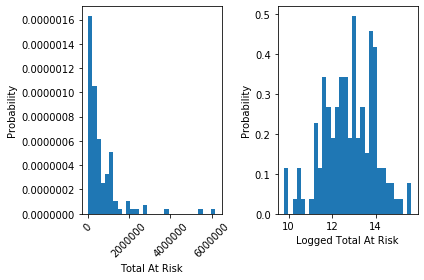

In [13]:
plt.subplot(1, 2, 1)
plt.hist(mmsa_df["total_at_risk"], density = True, bins = 30)
plt.ylabel("Probability")
plt.xlabel("Total At Risk")
plt.xticks(rotation = 45)

plt.subplot(1, 2, 2)
plt.hist(mmsa_df["total_at_risk_log"], density = True, bins = 30)
plt.ylabel("Probability")
plt.xlabel("Logged Total At Risk")

plt.tight_layout()
plt.show()

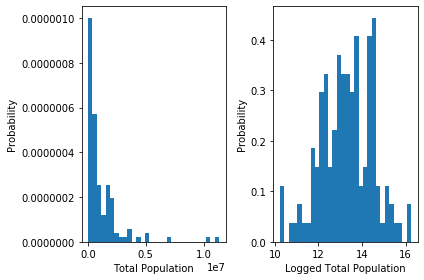

In [14]:
plt.subplot(1, 2, 1)
plt.hist(mmsa_df["total_population"], density = True, bins = 30)
plt.ylabel("Probability")
plt.xlabel("Total Population")

plt.subplot(1, 2, 2)
plt.hist(mmsa_df["total_population_log"], density = True, bins = 30)
plt.ylabel("Probability")
plt.xlabel("Logged Total Population")

plt.tight_layout()
plt.show()

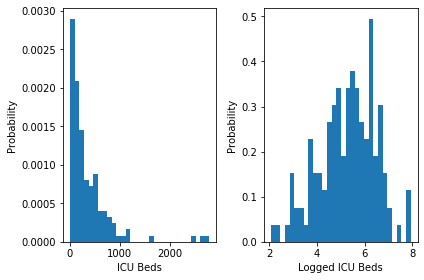

In [15]:
plt.subplot(1, 2, 1)
plt.hist(mmsa_df["icu_beds"], density = True, bins = 30)
plt.ylabel("Probability")
plt.xlabel("ICU Beds")

plt.subplot(1, 2, 2)
plt.hist(mmsa_df["icu_beds_log"], density = True, bins = 30)
plt.ylabel("Probability")
plt.xlabel("Logged ICU Beds")

plt.tight_layout()
plt.show()

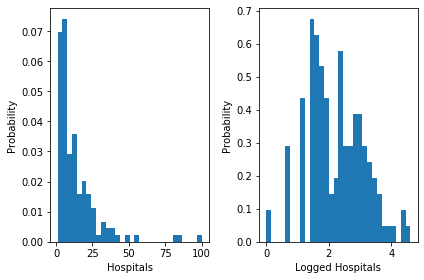

In [16]:
plt.subplot(1, 2, 1)
plt.hist(mmsa_df["hospitals"], density = True, bins = 30)
plt.ylabel("Probability")
plt.xlabel("Hospitals")

plt.subplot(1, 2, 2)
plt.hist(mmsa_df["hospitals_log"], density = True, bins = 30)
plt.ylabel("Probability")
plt.xlabel("Logged Hospitals")

plt.tight_layout()
plt.show()

The model we will try to fit is: $$(TotalAtRiskLog) = X$$ where `X` is: 

* `total_population_log`
* `icu_beds_log`
* `hospitals_log`
* Whether the MMSA is a Metropolitan Division or not
* Whether the MMSA spans multiple states or not

The features for our model are coded up. Before we model our target, we need to gain a bit of understanding of our features and how they relate to our target, `total_at_risk_log`. 

We first inspect Metropolitan Division. Metropiltan Divisions are more dense per county than non-Metropolitan Divisions. More people centrally located could indicate more people at risk. On the other hand, Metropolitan Divisions may have more resources available, curbing the amount of people at risk. Thus, we would expect `metro_div` to have either a positive or inverse effect on `total_at_risk_log`.

By simply inspecting the two groups, the data appear to be different. Whether positive or negative, the effect may be of a significant predictor in our model. 

In [17]:
mmsa_df.groupby("metro_div").agg({'total_at_risk_log':['count','mean','std','var']}).round(2)

total_at_risk_log                   
                      count   mean   std   var
metro_div                                     
0                       118  12.63  1.15  1.33
1                        17  13.81  0.74  0.54

We have two, independent groups we'd like to compare. However, the samples are not comparable in size. There are 118 non-Metropolitan Divisions and only 17 Metropolitan Divisions. Instead of the customary Student's T-Test, we'll use Welch's T-Test. Welch's T-Test assumes the two samples being compared have different variances, as can be assumed for this sample of data by inspecting the `var` in the table above. 

In [18]:
mmsa_metro = mmsa_df.loc[mmsa_df["metro_div"] == 1, "total_at_risk_log"]
mmsa_non_metro = mmsa_df.loc[mmsa_df["metro_div"] == 0, "total_at_risk_log"]

In [19]:
t, p = scipy.stats.ttest_ind(mmsa_metro, mmsa_non_metro, equal_var = False)
print("Null hypothesis: Metro Division and Non-Metro Divisions have similar means: H(0) = H(A)")
print("Alternative hypothesis: Metro Divisions and Non-Metro Divisions have different means: H(0) != H(A)")
print("\n")
print("T-stat: ", t.round(3))
print("P-value: ", p.round(3))

Null hypothesis: Metro Division and Non-Metro Divisions have similar means: H(0) = H(A)
Alternative hypothesis: Metro Divisions and Non-Metro Divisions have different means: H(0) != H(A)


T-stat:  5.666
P-value:  0.0


The result: The means of the Metropolitan and non-Metropolitan Divisions are statistically significantly different from each other at the 99% level of confidence. This means, Metropolitan Divisions are fundamentally different from non-Metropolitan Divisions.

Note, I am surprised the means are statistically significant from each other considering the sample size of Metropolitan Division is quite small. However, I suppose the groups are fundamentally different from each other in practicality, and the statistical test reflects this.  

Next, we'll inspect MMSA that span across multiple states. If an MMSA spans multiple states, the MMSA may face different laws/executive orders, meaning the total population at risk could vary within an MMSA. Intuitively, if an MMSA is within one state, their may be fewer people at risk. 

By simply inspecting the two groups, the data don't appear to be too different. 

In [20]:
mmsa_df.groupby("multiple_states").agg({'total_at_risk_log':['count','mean','std','var']})

total_at_risk_log                               
                            count       mean       std       var
multiple_states                                                 
0                             103  12.721176  1.180306  1.393123
1                              32  12.979516  1.150706  1.324124

In [21]:
mmsa_mult_st = mmsa_df.loc[mmsa_df["multiple_states"] == 1, "total_at_risk_log"]
mmsa_one_st = mmsa_df.loc[mmsa_df["multiple_states"] == 0, "total_at_risk_log"]

In [22]:
t, p = scipy.stats.ttest_ind(mmsa_one_st, mmsa_mult_st, equal_var = False)
print("Null hypothesis: Multiple and Non-Multiple States have similar means: H(0) = H(A)")
print("Alternative hypothesis: Multiple and Non-Multiple States have different means: H(0) != H(A)")
print("\n")
print("T-stat: ", t.round(3))
print("P-value: ", p.round(3))

Null hypothesis: Multiple and Non-Multiple States have similar means: H(0) = H(A)
Alternative hypothesis: Multiple and Non-Multiple States have different means: H(0) != H(A)


T-stat:  -1.103
P-value:  0.275


Our thery doesn't seem to hold. Our result suggests the means are not statistically significantly different from each other at the 90% level of confidence. This means, MMSA that span across multiple states are not different from MMSA that are completely in one state. 

This may be an unimportant feature which we can exclude as we tune our model. 

Let's identify the largest MMSA. 

In [23]:
tot_pop_top10 = mmsa_df.loc[:, ["MMSA","total_population"]]
tot_pop_top10 = tot_pop_top10.sort_values("total_population").tail(10)

(tot_pop_top10.sort_values("total_population", ascending = False).reset_index().drop("index", axis = 1)
 .style.format({"total_population": "{:,.0f}"}))

,MMSA,total_population
0,"New York-Jersey City-White Plains, NY-NJ, Metropolitan Division","11,337,076"
1,"Los Angeles-Long Beach-Anaheim, CA","10,454,714"
2,"Chicago-Naperville-Elgin, IL-IN-WI","6,839,764"
3,"Houston-The Woodlands-Sugar Land, TX","5,140,605"
4,"Miami-Fort Lauderdale-West Palm Beach, FL","4,929,318"
5,"Atlanta-Sandy Springs-Roswell, GA","4,470,723"
6,"Washington-Arlington-Alexandria, DC-VA-MD-WV, Metropolitan Division","3,786,785"
7,"Dallas-Plano-Irving, TX, Metropolitan Division","3,650,681"
8,"Phoenix-Mesa-Scottsdale, AZ","3,630,310"
9,"Riverside-San Bernardino-Ontario, CA","3,401,601"


Let's identify the MMSA with the most people at risk.

In [24]:
tot_at_risk_top10 = mmsa_df.loc[:, ["MMSA","total_at_risk"]]
tot_at_risk_top10 = tot_at_risk_top10.sort_values("total_at_risk").tail(10)

(tot_at_risk_top10.sort_values("total_at_risk", ascending = False).reset_index().drop("index", axis = 1)
 .style.format({"total_at_risk": "{:,.0f}"}))

,MMSA,total_at_risk
0,"New York-Jersey City-White Plains, NY-NJ, Metropolitan Division","6,165,102"
1,"Los Angeles-Long Beach-Anaheim, CA","5,345,495"
2,"Chicago-Naperville-Elgin, IL-IN-WI","3,831,636"
3,"Houston-The Woodlands-Sugar Land, TX","2,869,486"
4,"Miami-Fort Lauderdale-West Palm Beach, FL","2,749,081"
5,"Atlanta-Sandy Springs-Roswell, GA","2,467,392"
6,"Phoenix-Mesa-Scottsdale, AZ","2,096,504"
7,"Riverside-San Bernardino-Ontario, CA","1,925,986"
8,"Dallas-Plano-Irving, TX, Metropolitan Division","1,916,243"
9,"Washington-Arlington-Alexandria, DC-VA-MD-WV, Metropolitan Division","1,894,529"


When looking at these two lists, the top six observations remain unchanged. Further, the top 10 in total population are in the top 10 in total population at risk. This gives us an idea that the more people living in an MMSA, the more at risk people are. This could be due to larger MMSA naturally having a larger total at risk population. This pattern may hold for the largest MMSA, but not necessarily for the rest of the dataset. We need to keep in mind that MMSA with larger total populations may also have more resources available, thus possibly curbing the total population at risk. 

Let's look at the correlations between these features.

In [25]:
mmsa_df['total_population_log'].corr(mmsa_df['total_at_risk_log'])

0.9964553854668807

Looks like total population and total at risk are highly correlated, leading us to believe total population at risk may increase when total population increases. This can be somewhat expected, according to theory, and/or the fact that we did use `total_at_risk` to calculate `total_population`:    

`total_at_risk` / `total_percent_at_risk`

This, in practice, would not be ideal when modeling the target variable. For this exercise, it is purely a demonstration of feature generation and modeling.

In [26]:
mmsa_df['icu_beds_log'].corr(mmsa_df['total_at_risk_log'])

0.9431210012654813

In [27]:
mmsa_df['hospitals_log'].corr(mmsa_df['total_at_risk_log'])

0.9127880266881997

The number of ICU Beds and Hospitals available in an MMSA could be expected to help or adversely affect the total number of people at risk. We can expect the more ICU Beds and Hospitals in an MMSA, the lower the total at risk population should be. On the contrary, since we may expect MMSA with higher total populations to have a higher total at risk population, MMSA with higher total populations may also be expected to have more ICU Beds and Hospitals to support the larger populations. This also means that Metropolitan Divisions may also see more ICU Beds and Hospitals. We may be dealing with severe multicollinearity in this dataset.

Inspecting the correlation coefficients indicates a strong positive relationship as positive correlations are found between ICU Beds and Hositals and our target. Negative correlations would have indicated an inverse relationship between ICU Beds and Hospitals and the total at risk population. 

ICU Beds and Hospitals may be closer linked to total population rather than the total at risk population. 

Now, we have some understanding of how we expect our variables to interact with our target in our model. 

Let's begin building our model: 

First, we split our dataset into training and test sets. 

In [28]:
mmsa_df_model = mmsa_df.copy()
random.seed(19)
mmsa_df_model["split"] = [random.random() for k in mmsa_df_model.index]

In [29]:
train_df = mmsa_df_model[mmsa_df_model["split"] <= 0.8]
test_df = mmsa_df_model[mmsa_df_model["split"] > 0.8]
print(mmsa_df.shape)
print(train_df.shape)
print(test_df.shape)

(135, 14)
(115, 15)
(20, 15)


In [30]:
train_x = train_df[["total_population_log","hospitals_log","icu_beds_log","metro_div","multiple_states"]]
train_y = train_df[["total_at_risk_log"]]
test_x = test_df[["total_population_log","hospitals_log","icu_beds_log","metro_div","multiple_states"]]
test_y = test_df[["total_at_risk_log"]]

print(train_x.shape)
print(train_y.shape)
print(test_x.shape)
print(test_y.shape)

(115, 5)
(115, 1)
(20, 5)
(20, 1)


Estimate initial OLS model:

In [32]:
# statsmodels function doesn't include a constant term, so, add a constant term to the equation.
X = sm.add_constant(train_x)
model = sm.OLS(train_y, X).fit() ## sm.OLS(output, input)

# Print out the statistics
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:      total_at_risk_log   R-squared:                       0.994
Model:                            OLS   Adj. R-squared:                  0.994
Method:                 Least Squares   F-statistic:                     3847.
Date:                Tue, 12 May 2020   Prob (F-statistic):          8.26e-121
Time:                        18:57:36   Log-Likelihood:                 122.38
No. Observations:                 115   AIC:                            -232.8
Df Residuals:                     109   BIC:                            -216.3
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
========================================================================================
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                    0.3242      0.230      1.409      0.162      -0.132       0.780
total_population_log     0.9054      0.025     36.668      0.000       0.856       0.954
hospitals_log           -0.0016      0.022     -0.071      0.943      -0.046       0.043
icu_beds_log             0.0814      0.020      4.097      0.000       0.042       0.121
metro_div               -0.0360      0.028     -1.287      0.201      -0.092       0.019
multiple_states          0.0311      0.019      1.646      0.103      -0.006       0.069
==============================================================================
Omnibus:                        3.778   Durbin-Watson:                   1.650
Prob(Omnibus):                  0.151   Jarque-Bera (JB):                3.262
Skew:                          -0.302   Prob(JB):                        0.196
Kurtosis:                       3.563   Cond. No.                         424.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

The Adjusted-R^2 is pretty high, which is a positive outcome, considering this is a cross-sectional dataset. Our AIC and BIC are pretty low, also a good indicator. Lastly, our F-Statistic is pretty high, indicating the group of features we have in our model is an appropriate group. 

At a high level, the model seems healthy. From a feature level, some enhancements could be made. `hospitals_log` is statistically insignificant in the model, with a p-value close to 1. We saw earlier `hospitals_log`, `icu_bed_log`, and `total_population_log` are all highly positively correlated with `total_at_risk_log`. `hospitals_log`, `icu_beds_log`, and`total_population_log` may be highly correlated to each other as well. 

Let's inspect the variance inflation factors (VIF) for our features.

In [33]:
pd.Series([variance_inflation_factor(X.values, i) 
           for i in range(X.shape[1])], 
          index = X.columns)

const                   828.645829
total_population_log     12.230192
hospitals_log             5.835775
icu_beds_log              8.163369
metro_div                 1.145753
multiple_states           1.004478
dtype: float64

Let's also see how well we're scoring unseen data.

In [34]:
# Estimate predictions on train and test datasets
predictions_train = model.predict(X)
predictions_test = model.predict(sm.add_constant(test_x))

# Calculate the absolute errors
errors_train = abs(predictions_train - train_y.iloc[:, 0])
errors_test = abs(predictions_test - test_y.iloc[:, 0])

# Print out the mean absolute error (mae)
print("Training Mean Absolute Error: ", round(np.mean(errors_train), 5))
print("Testing Mean Absolute Error: ", round(np.mean(errors_test), 5))

Training Mean Absolute Error:  0.06272
Testing Mean Absolute Error:  0.08532


The baseline MAE on our test dataset is `0.08532`. 

`total_population_log` seems to be collinear with some other features as can be noticed with a VIF > 10. However, let's keep `total_population_log` in the model, and instead exclude `hospitals_log` as this feature is not statistically significant in the model. 

Let's also exclude `multiple_states` since it is not statistically significant in our model at the 90% level of confidence. Further, the T-Test earlier showed the statistical insignifcance of the two groups of `multiple_states`. We keep `metro_div` as we theoretically believe there is something fundamentally different about those two groups. 

Let's see what happens. 

In [35]:
train_x = train_df[["total_population_log","icu_beds_log","metro_div"]]
train_y = train_df[["total_at_risk_log"]]
test_x = test_df[["total_population_log","icu_beds_log","metro_div"]]
test_y = test_df[["total_at_risk_log"]]

X = sm.add_constant(train_x)
model = sm.OLS(train_y, X).fit()

model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:      total_at_risk_log   R-squared:                       0.994
Model:                            OLS   Adj. R-squared:                  0.994
Method:                 Least Squares   F-statistic:                     6369.
Date:                Tue, 12 May 2020   Prob (F-statistic):          4.95e-124
Time:                        18:57:46   Log-Likelihood:                 120.97
No. Observations:                 115   AIC:                            -233.9
Df Residuals:                     111   BIC:                            -223.0
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
========================================================================================
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                    0.3462      0.180      1.926      0.057      -0.010       0.702
total_population_log     0.9037      0.021     43.898      0.000       0.863       0.945
icu_beds_log             0.0821      0.020      4.147      0.000       0.043       0.121
metro_div               -0.0383      0.028     -1.368      0.174      -0.094       0.017
==============================================================================
Omnibus:                        3.073   Durbin-Watson:                   1.699
Prob(Omnibus):                  0.215   Jarque-Bera (JB):                2.608
Skew:                          -0.231   Prob(JB):                        0.271
Kurtosis:                       3.575   Cond. No.                         327.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [36]:
predictions_train = model.predict(X)
predictions_test = model.predict(sm.add_constant(test_x))

errors_train = abs(predictions_train - train_y.iloc[:, 0])
errors_test = abs(predictions_test - test_y.iloc[:, 0])

print("Training Mean Absolute Error: ", round(np.mean(errors_train), 5))
print("Testing Mean Absolute Error: ", round(np.mean(errors_test), 5))

Training Mean Absolute Error:  0.06389
Testing Mean Absolute Error:  0.08191


Our test MAE decreased from `0.08532` to `0.08191` (4% improvement). 

Further, our training MAE is closer to our testing MAE than the first model, indicating a more generalizable model to use for scoring. 

The Adjusted-R^2 remains unchanged. However, our AIC and BIC decrease (a good indicator). The F-Statistic increases (a good indicator).  

A comment on `metro_div`. Just because a feature is not statistically significant, doesn't mean it should be excluded from your model. `metro_div` still captures some qualitative information necessary to capture the pattern in the data. If we conduct one more model (not featured here) with only `total_population_log`,`icu_beds_log`, excluding `metro_div`, our test MAE jumps to `0.08496`. This proves we need to keep `metro_div` in our model.  

In [37]:
pd.Series([variance_inflation_factor(X.values, i) 
           for i in range(X.shape[1])], 
          index = X.columns)

const                   501.870186
total_population_log      8.448365
icu_beds_log              8.071057
metro_div                 1.137040
dtype: float64

The VIF for our features seem like they are able to be improved. A rule of thumb on VIF, generally VIF < 10 is a good indicator, some schools of thought refer to a VIF < 5. We have demonstrated how to improve a model via feature generation (binary features), feature engineering (log), and removing multicollinearity. But let's push a little further. 

Let's try one more model with only `total_population_log` and `metro_div`. Let's attempt to rid our model completely of multicollinearity.

In [38]:
train_x = train_df[["total_population_log","metro_div"]]
train_y = train_df[["total_at_risk_log"]]
test_x = test_df[["total_population_log","metro_div"]]
test_y = test_df[["total_at_risk_log"]]

X = sm.add_constant(train_x)
model = sm.OLS(train_y, X).fit()

model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:      total_at_risk_log   R-squared:                       0.993
Model:                            OLS   Adj. R-squared:                  0.993
Method:                 Least Squares   F-statistic:                     8340.
Date:                Tue, 12 May 2020   Prob (F-statistic):          1.42e-122
Time:                        18:57:54   Log-Likelihood:                 112.69
No. Observations:                 115   AIC:                            -219.4
Df Residuals:                     112   BIC:                            -211.1
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
========================================================================================
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                   -0.2775      0.105     -2.638      0.010      -0.486      -0.069
total_population_log     0.9834      0.008    123.712      0.000       0.968       0.999
metro_div               -0.0591      0.029     -2.008      0.047      -0.117      -0.001
==============================================================================
Omnibus:                        1.704   Durbin-Watson:                   1.699
Prob(Omnibus):                  0.426   Jarque-Bera (JB):                1.222
Skew:                          -0.109   Prob(JB):                        0.543
Kurtosis:                       3.455   Cond. No.                         165.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [39]:
predictions_train = model.predict(X)
predictions_test = model.predict(sm.add_constant(test_x))

errors_train = abs(predictions_train - train_y.iloc[:, 0])
errors_test = abs(predictions_test - test_y.iloc[:, 0])

print("Training Mean Absolute Error: ", round(np.mean(errors_train), 5))
print("Testing Mean Absolute Error: ", round(np.mean(errors_test), 5))

Training Mean Absolute Error:  0.07158
Testing Mean Absolute Error:  0.07621


In [40]:
pd.Series([variance_inflation_factor(X.values, i) 
           for i in range(X.shape[1])], 
          index = X.columns)

const                   150.328762
total_population_log      1.100299
metro_div                 1.100299
dtype: float64

WOW! Our model looks great! Our Adjusted-R^2 is approximately the same. Our F-Statistic increased, although it already was statistically significant. Our AIC and BIC did increase, generally not a good indicator. However, we have made substantial improvement in our test MAE, `0.07621`, a 10.7% improvement from our base model!  The fact that our train MAE and test MAE are similar means we are not overfitting our model as earlier models may have been, even when earlier models had a handful of features.

We can firmly express, for sake of interpretation, that a 1% increase in total population leads to a 0.98% increase in the total population at risk. This illustrates that higher populated areas are more at risk. Further, if an MMSA is a Metropolitan Division, the total population at risk decreases by 0.06%. This demonstrates that more resources available in Metropolitan Divisions do make a difference to decrease the total population at risk. 

Just to prove that we made the right decision among which features to include in the model - choosing `total_population_log` instead of `icu_beds_log`, as both have approximately the same VIF - let's quickly estimate the test MAE of a model with features `icu_beds_log` and `metro_div`.

In [41]:
train_x = train_df[["icu_beds_log","metro_div"]]
train_y = train_df[["total_at_risk_log"]]
test_x = test_df[["icu_beds_log","metro_div"]]
test_y = test_df[["total_at_risk_log"]]

X = sm.add_constant(train_x)
model = sm.OLS(train_y, X).fit()

predictions_train = model.predict(X)
predictions_test = model.predict(sm.add_constant(test_x))

errors_train = abs(predictions_train - train_y.iloc[:, 0])
errors_test = abs(predictions_test - test_y.iloc[:, 0])

print("Training Mean Absolute Error: ", round(np.mean(errors_train), 5))
print("Testing Mean Absolute Error: ", round(np.mean(errors_test), 5))

Training Mean Absolute Error:  0.26571
Testing Mean Absolute Error:  0.33461


When estimating a model with `icu_beds_log` and `metro_div` instead of `total_population_log` and `metro_div`, our MAE skyrocket. 

We have a champion model. 

$$ (TotalAtRiskLog) = B(0) + B(1)(TotalPopulationLog) + B(2)(MetroDiv) $$

Let's see how an ensemble method stacks up to our OLS model. 

In [42]:
train_x = train_df[["total_population_log","metro_div"]]
train_y = train_df[["total_at_risk_log"]]
test_x = test_df[["total_population_log","metro_div"]]
test_y = test_df[["total_at_risk_log"]]

# Instantiate model with 1000 decision trees
rf = RandomForestRegressor(n_estimators = 100, random_state = 42)

# Train the model on training data
rf.fit(train_x, train_y.iloc[:,0])

predictions_rf_train = rf.predict(train_x)
predictions_rf_test = rf.predict(test_x)

errors_train = abs(predictions_rf_train - train_y.iloc[:, 0])
errors_test = abs(predictions_rf_test - test_y.iloc[:, 0])

print("Training Mean Absolute Error: ", round(np.mean(errors_train), 5))
print("Testing Mean Absolute Error: ", round(np.mean(errors_test), 5))

Training Mean Absolute Error:  0.04038
Testing Mean Absolute Error:  0.10914


Our Random Forest estimator doesn't outperform our OLS model. Let's try to tune the model with some different parameters.

In [43]:
rf = RandomForestRegressor(n_estimators = 1000, # default = 100
                           min_samples_split = 3, # default = 2
                           min_samples_leaf = 2, # default = 1
                           min_impurity_decrease = 0.0001, # default = 0
                           random_state = 42
                          )

rf.fit(train_x, train_y.iloc[:,0])

predictions_rf_train = rf.predict(train_x)
predictions_rf_test = rf.predict(test_x)

errors_train = abs(predictions_rf_train - train_y.iloc[:, 0])
errors_test = abs(predictions_rf_test - test_y.iloc[:, 0])

print("Training Mean Absolute Error: ", round(np.mean(errors_train), 5))
print("Testing Mean Absolute Error: ", round(np.mean(errors_test), 5))

Training Mean Absolute Error:  0.06284
Testing Mean Absolute Error:  0.14084


It seems that tuning the parameters, attempting to make the model more generalizable to unseen data, increases our MAE (as expected, but doesn't improve our outcome). Our Random Forest model seems to be overfit, or at least may need some more predictive features, as can be seen by the wide range between the MAE of the training dataset and test dataset.

Our OLS model stands as our best model. Though ensembling methods may prove superior for more complex, larger datasets, OLS performs well when all of it's assumptions are met and the pattern in the data is largely linear, as we've seen with the correlation and model coefficients. With a small dataset and only two features, Random Forest ensembling, a tree-based method, is limited in capturing the linear relationships. 

##### A few caveats

We need to remember that we used our target variable to calculate one of our features, total population. This was done to simply demonstrate the data preparation and modeling processes, not to make a determination on the risk of COVID-19. 

This project is meant to be a fun demonstration of a data science process. 

Thank you for reading!